In [3]:
import multiprocessing as mp
import netket as nk
import os
import json
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from functools import reduce
from time import time
from scipy.optimize import minimize
from matplotlib import gridspec
import copy
import pickle
import optax

In [4]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()
    

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

def CSHam(N, B, Ak):
    # Make graph with of length N with no periodic boundary conditions
    g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
    # Spin based Hilbert Space
    hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    # Define spin operators with \hbar set to 1
    sz = 0.5 * np.array([[1, 0], [0, -1]])
    sx = 0.5 * np.array([[0, 1], [1, 0]])
    sy = 0.5 * np.array([[0, -1j], [1j, 0]])
    operators = []
    sites = []
    # Central spin term
    operators.append((B * sz).tolist()) #array to list(ordered and changeable)
    sites.append([0])
    # Interaction term
    itOp = np.kron(sz, sz) + np.kron(sx, sx) + np.kron(sy, sy) #kronecker product here
    for i in range(N - 1):
        operators.append((Ak[i] * itOp).tolist())
        sites.append([0, (i+1)])  #pretty convoluted indexing, but ok
    # Create hamiltonian
    hamiltonian = nk.operator.LocalOperator(hilbertSpace, operators=operators, acting_on=sites, dtype=complex)
    #acting_on specifier necessary as this is a central spin model
    return hamiltonian, hilbertSpace

def exactDiagonalization_full(hamiltonian):
    # Changes Hamiltonian to matrix form
    haMatrix = hamiltonian.to_dense()
    # Gets eigenvalues and vectors
    eigenValues, v = np.linalg.eigh(haMatrix)
    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors

def state_error(state_list, ex_state_list, N):
    state_er = []
    for i in range(len(state_list)):
        state_er_temp = err_sta(state_list[i], ex_state_list[i], N)
        state_er.append(state_er_temp)
    return state_er

# Error Calculation (Input: the found state, the state from exact diagonalization, the found energy, the energy from exact diagonalization)
def err_sta(state, edState,N):
    overlap = np.dot(state.conj().reshape(2**N, 1).T, edState.reshape(2**N, 1))
    waveFunctionErr = 1 - (np.linalg.norm(overlap))**2
    return waveFunctionErr

def eng_error(eng_list, ex_energy):
    eng_er = []
    for i in range(len(eng_list)):
        eng_er_temp = np.abs(eng_list[i] - ex_energy[i])
        eng_er.append(eng_er_temp)
    return eng_er

In [5]:
def expected_2(A, bra, ket):
        
    expectation = np.dot(np.conj(bra).T, np.matmul(A, ket) )
    return expectation


#evolve correlation function
def evo_corr(t_obver, obver, sta_list, eng_list, t_end, t_step, N):
    num_step = int(np.around(t_end / t_step))
    time = []
    correlation = []
    
    coeff = np.ones(len(eng_list), dtype = complex)
    
    for i in range(num_step+1):
        time.append(t_step*(i))
        corr_temp = complex(0,0)
        
        for j in range(len(eng_list)):
            op = np.exp(- 1j * (eng_list[j]-eng_list[0]) * t_step)
            coeff[j] = op * coeff[j]
            ket_j = coeff[j] * sta_list[j]
            corr_temp += expected_2(t_obver, sta_list[0], ket_j) * expected_2(obver, sta_list[j], sta_list[0])
        
        correlation.append(corr_temp)
            
    return time, correlation

In [6]:
N = 6
Ak = []

alpha = 1   #density of RBM
M = alpha*N
# Constant A
B = 0.95
# Variable A
A = N/2
N0 = N/2
for i in range(N-1):
    # Constant A
    #Ak_i = 1
    # Variable A
    Ak_i = A / (N0) * np.exp(-i / N0)
    Ak.append(Ak_i)
    
# Define hamiltonian and hilbert space
ha, hi = CSHam(N,B,Ak)


#Exact Diagonalization
e, v = exactDiagonalization_full(ha)


In [12]:
eng_list = np.loadtxt("2021_summer_data/temp_data/eng_4.json")
state_list = np.loadtxt("2021_summer_data/temp_data/state_4.json", dtype = complex)

print(eng_list[1])    

-1.3278155640249427


In [13]:
print('exact energy',e[0],e[1],e[2],e[3],e[4])
print('RBM energy', eng_list[0], eng_list[1], eng_list[2], eng_list[3], eng_list[4])
print('energy error', eng_error(eng_list, e))
print('state error', state_error(state_list,v,N))

exact energy -1.415249431708348 -1.3277123197988363 -1.2714515823104722 -1.2198800483094723 -1.198764780197216
RBM energy -1.4152514732915125 -1.3278155640249427 -1.2715227314873638 -1.2198186307873775 -1.1988832538713954
energy error [2.0415831645248517e-06, 0.0001032442261064137, 7.114917689166056e-05, 6.141752209476437e-05, 0.00011847367417927579]
state error [0.00028318488519929463, 0.0003905715099571383, 0.00033294792020366337, 0.00013839812054605716, 0.0002135329249308704]


In [30]:
#construct the S+0 and S-0 operators of interest
def S0_p(N):
    S0_p = []
    si = qeye(2)
    op_list = []
    for m in range(N):     
        op_list.append(si)
    op_list[0] = sigmap()
    S0_p.append(tensor(op_list))
    
    return S0_p[0]

def S0_m(N):
    S0_m = []
    si = qeye(2)
    op_list = []
    for m in range(N):     
        op_list.append(si)
    op_list[0] = sigmam()
    S0_m.append(tensor(op_list))
    
    return S0_m[0]

obver_p = np.array(S0_p(N))
obver_m = np.array(S0_m(N))

def phase_fix(rbm_list, exact_list, N):
    fixed_rbm_list = []
    for i in range(len(rbm_list)):
        overlap = np.dot(rbm_list[i].conj().reshape(2**N, 1).T, exact_list[i].reshape(2**N, 1))
        angle = np.angle(overlap)
        fixed_rbm_list.append(np.exp(1j*np.angle(overlap))[0][0] * rbm_list[i])
    return fixed_rbm_list

state_list = phase_fix(state_list,v,N)

In [31]:
time, corr = evo_corr(obver_p, obver_m, state_list, eng_list, 200, 0.05, N )

time_ex, corr_ex = evo_corr(obver_p, obver_m, v, e, 200, 0.05, N )

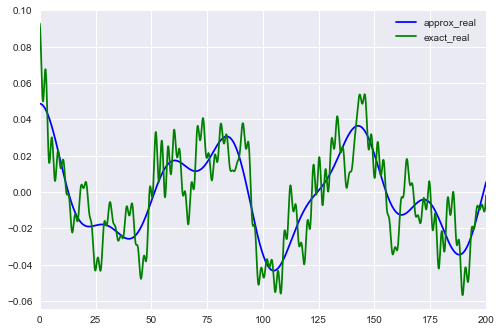

In [32]:
plt.plot(time, np.real(corr), color='b', label = 'approx_real')
plt.plot(time_ex, np.real(corr_ex), color='g', label = 'exact_real')
#plt.ylim(-0.383,-0.3829)
plt.legend()
plt.xlim(0, 200)
plt.show()

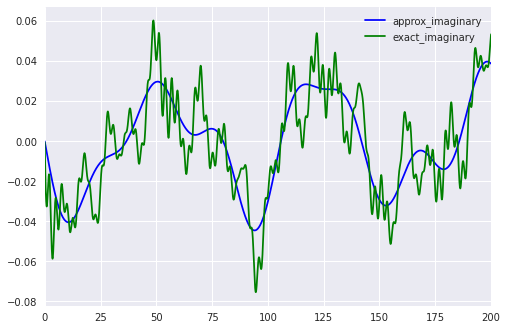

In [166]:
plt.plot(time, np.imag(corr), color='b', label = 'approx_imaginary')
plt.plot(time_ex, np.imag(corr_ex), color='g', label = 'exact_imaginary')
#plt.ylim(-0.383,-0.3829)
plt.xlim(0,200)
plt.legend()
plt.show()

In [162]:
def power_spectrum(sig):
    sig_fft = scipy.fftpack.fft(sig)

    # And the power (sig_fft is of complex dtype)
    power = np.abs(sig_fft)**2

    # The corresponding frequencies
    sample_freq = scipy.fftpack.fftfreq(sig.size, d=1/100)

    
    return sample_freq, power

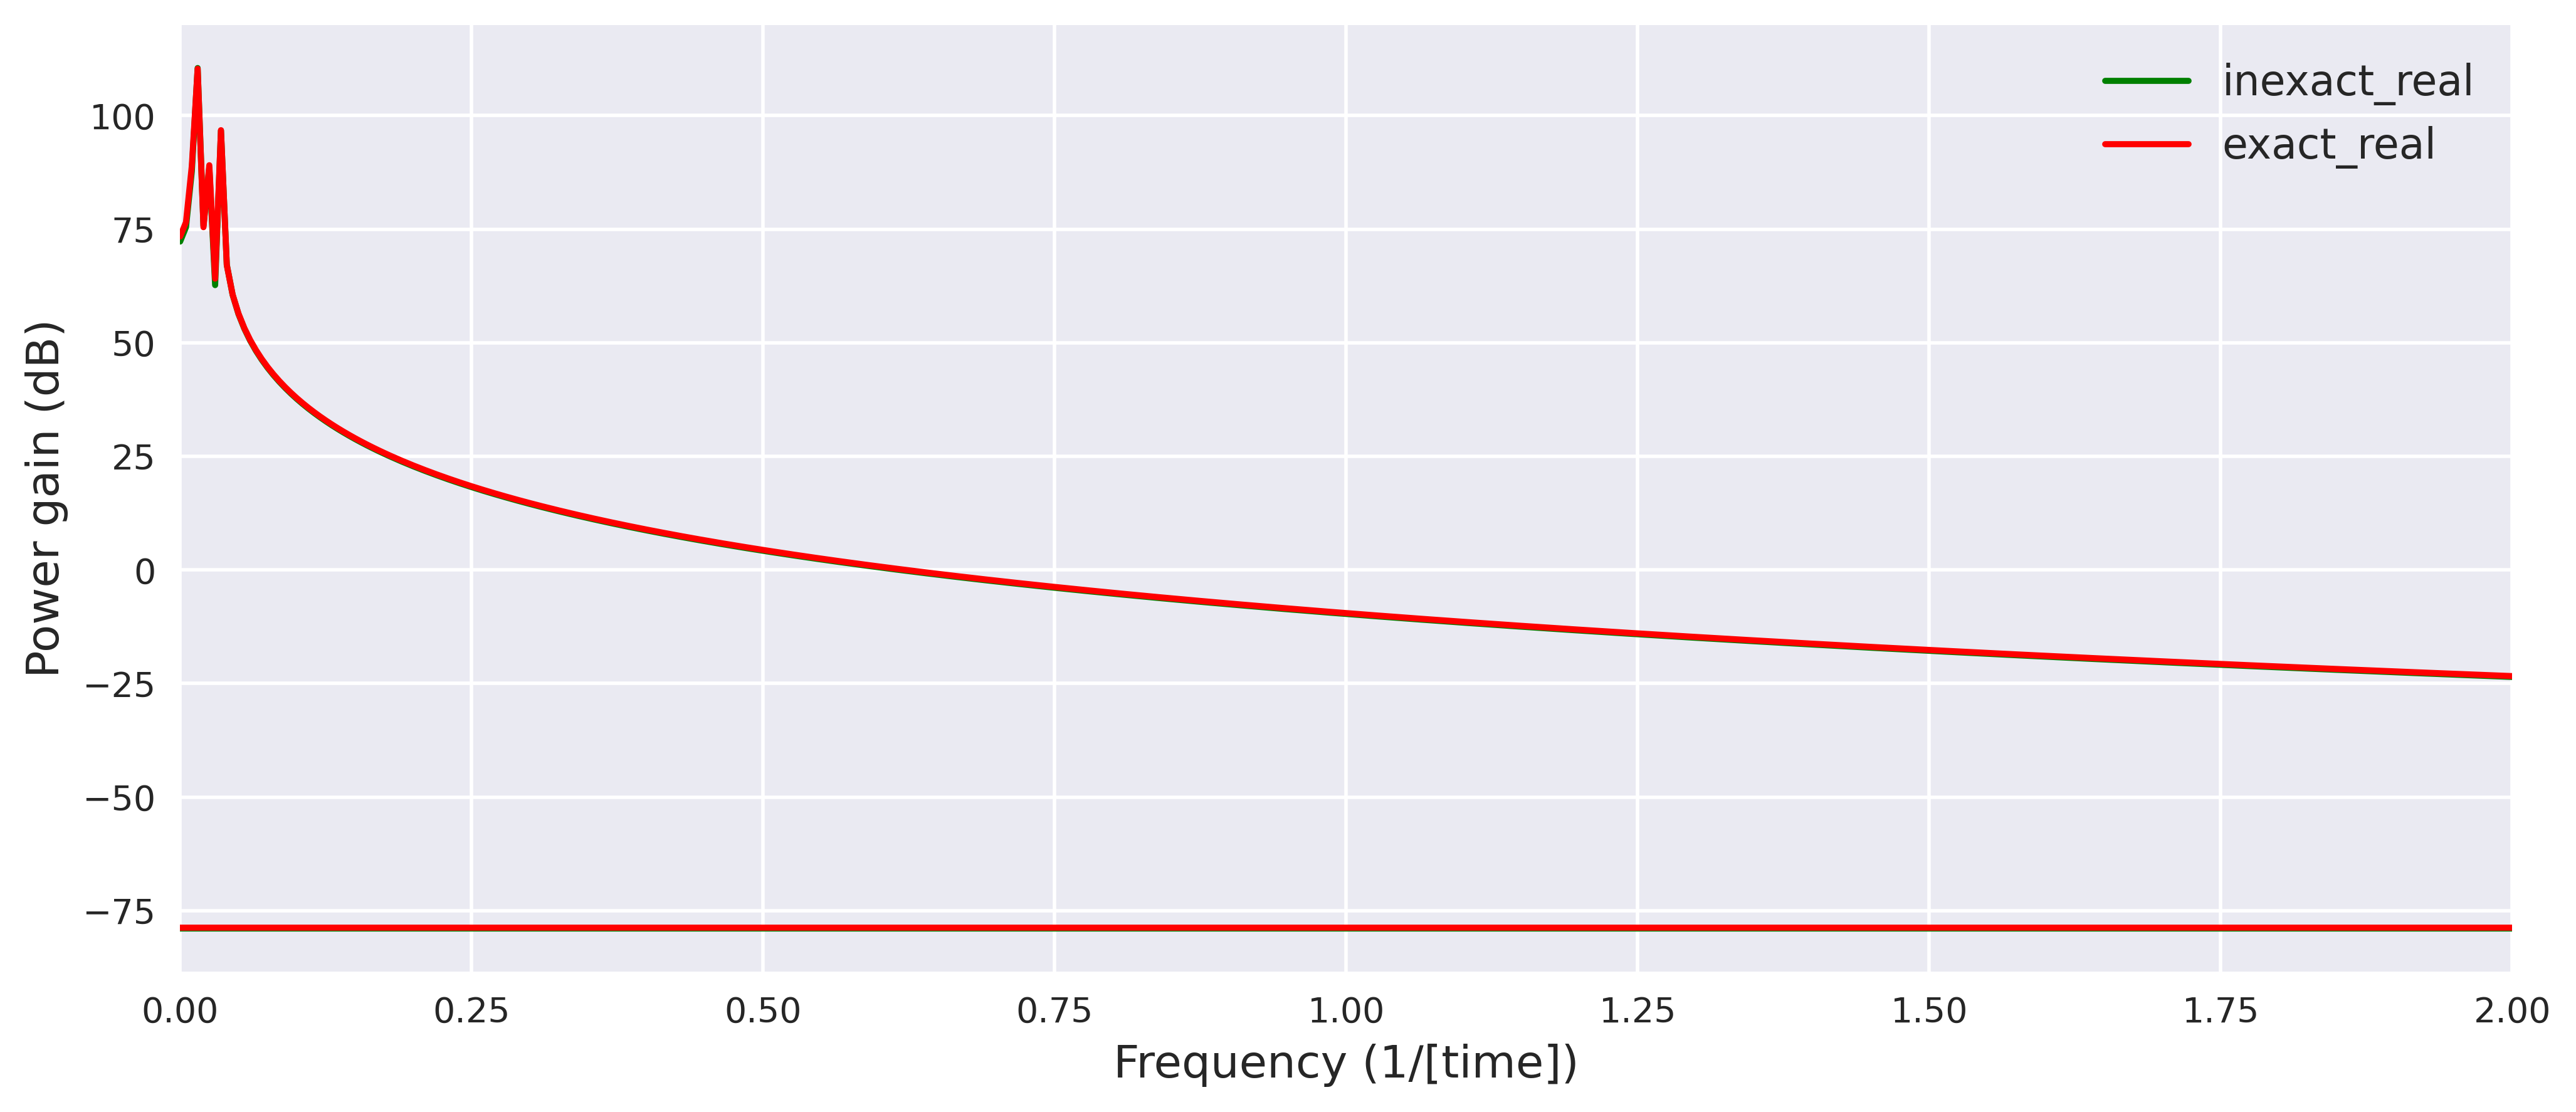

In [163]:
sample_freq_ex, power_ex = power_spectrum(np.imag(corr_ex))
sample_freq, power = power_spectrum(np.imag(corr))

# Plot the FFT power
plt.figure(figsize=(12, 5),dpi=400)
plt.plot(sample_freq, 10*np.log(power), 'g', label = 'inexact_real')
plt.plot(sample_freq_ex, 10*np.log(power_ex), 'r', label='exact_real')
plt.xlim(left=0, right=2)
#plt.ylim(-10)
plt.xlabel('Frequency (1/[time])',fontsize=13)
plt.ylabel('Power gain (dB)',fontsize=13)
plt.legend(fontsize=12)